In [1]:
# Importação das bibliotecas
import keras
import numpy as np
from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score
)
import tensorflow as tf
import matplotlib.pyplot as plt

import os


from src.config import (
    TRAIN_DIR, TEST_DIR,
    RANDOM_STATE,
    MODELS_DIR, LOGS_DIR
    )
from src.graphics import plotConfusionMatrix, plotGradcam
from src.models import makeGradcamHeatmap

2025-05-18 23:41:01.664055: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 23:41:01.798517: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 23:41:01.912547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747622462.017748     412 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747622462.048524     412 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747622462.266270     412 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
# Redução da quantidade de nucleos usados para treino

os.environ["OMP_NUM_THREADS"] = "2"  # Threads para operações paralelas (OpenMP)
os.environ["TF_NUM_INTRAOP_THREADS"] = "2"
os.environ["TF_NUM_INTEROP_THREADS"] = "1"

tf.config.threading.set_intra_op_parallelism_threads(2) # Threads usadas por uma operação para paralelismo
tf.config.threading.set_inter_op_parallelism_threads(1) # Número de operações simultâneas (paralelismo) que o runtime pode agendar

In [ ]:
# Hiperparametros
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.1
EPOCHS = 50

In [4]:
# Carregando as imagens de treino
train_dataset = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    class_names=["no_finding", "effusion"],
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=RANDOM_STATE
)

Found 5534 files belonging to 2 classes.


2025-05-18 23:41:14.194609: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
# Carregando as imagens de teste
test_dataset = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    class_names=["no_finding", "effusion"],
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=RANDOM_STATE
)

Found 19293 files belonging to 2 classes.


In [6]:
# Parametros para a CNN
NUM_CLASSES = 2
INPUT_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

In [7]:
# Definição da CNN (modelo)
model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])

/home/lucas/Documentos/python/pleural_effusion_classification/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Compilação do modelo
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [9]:
# Sumário do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,838,529 (56.60 MB)

 Trainable params: 14,838,529 (56.60 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Definição dos callbacks

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(MODELS_DIR, "model.keras"),
        monitor="val_loss",
        save_best_only=True
    ),
    keras.callbacks.CSVLogger(
        os.path.join(LOGS_DIR, "model_metrics.csv")
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2
    )
]

In [11]:
# Ajuste de pesos da CNN
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/10


2025-05-18 23:41:33.946457: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.
2025-05-18 23:41:35.796043: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.


  1/173 ━━━━━━━━━━━━━━━━━━━━ 11:45 4s/step - accuracy: 0.3750 - loss: 7.4170

2025-05-18 23:41:36.361248: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.
2025-05-18 23:41:38.072090: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.


  2/173 ━━━━━━━━━━━━━━━━━━━━ 6:04 2s/step - accuracy: 0.4062 - loss: 34.3972

2025-05-18 23:41:38.490023: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.


173/173 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.5318 - loss: 10.5305
Epoch 2/10


/home/lucas/Documentos/python/pleural_effusion_classification/venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/home/lucas/Documentos/python/pleural_effusion_classification/venv/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.5912 - loss: 0.6769
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.5969 - loss: 0.6585
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.6338 - loss: 0.6320
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.6437 - loss: 0.6193
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.6935 - loss: 0.5716
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.7361 - loss: 0.5122
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.7767 - loss: 0.4577
Epoch 9/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.8025 - loss: 0.4240
Epoch 10/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.8314 - loss: 0.3738


In [13]:
# Previsão com os dados de teste
y_pred = np.where(model.predict(test_dataset) > 0.5, 1, 0).reshape(-1)

603/603 ━━━━━━━━━━━━━━━━━━━━ 287s 475ms/step


In [14]:
y_pred

array([1, 1, 1, ..., 0, 1, 1])

In [15]:
# Valores verdadeiros
y_true = np.array([])

for _, y in test_dataset:

    y_true = np.concatenate((y_true, y.numpy()), axis=0)

2025-05-19 00:50:00.593702: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
y_true

array([0., 0., 1., ..., 0., 0., 0.])

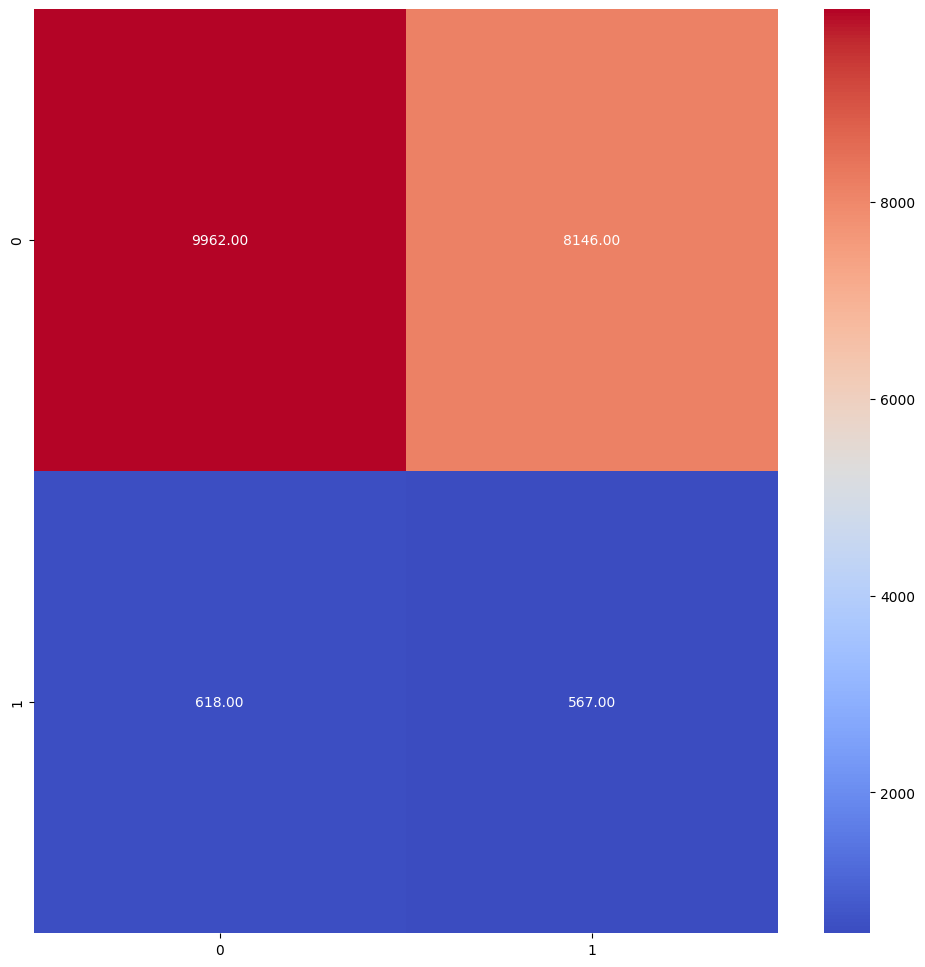

In [21]:
# Matriz de confusão
_ = plotConfusionMatrix(confusion_matrix(y_true, y_pred))

In [22]:
# Métricas

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"{'Acurácia':<15} | {'Recall':>15}")
print(f"{accuracy:<15.2f} | {recall:>15.2f}")

Acurácia        |          Recall
0.55            |            0.48


In [24]:
# Salvando o modelo
model.save(
    os.path.join(MODELS_DIR, f"model_{accuracy*100:.0f}_acc_{recall*100:.0f}_rec.keras")
    )